In [7]:
%config InlineBackend.figure_format = 'svg'

import os
import torch
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from my_models import Transformer1d
from my_utilities import MatReader,count_params,mytrain

seed = 0


os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.set_printoptions(precision=16)

In [8]:
model_path="model1d.pth"
model = torch.load(model_path)
model.eval()

Transformer1d(
  (fc0): Linear(in_features=2, out_features=128, bias=True)
  (encoders): ModuleList(
    (0-3): 4 x AttentionEncoder(
      (linears): ModuleList(
        (0-2): 3 x Linear(in_features=128, out_features=128, bias=True)
      )
      (layernorms_K): ModuleList(
        (0-7): 8 x LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      )
      (layernorms_V): ModuleList(
        (0-7): 8 x LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (decoder): GalerkinDecoder(
    (galerkin_layers): ModuleList(
      (0): GalerkinLayer1d(
        (act): SiLU()
        (linear): Linear(in_features=128, out_features=64, bias=True)
      )
      (1-7): 7 x GalerkinLayer1d(
        (act): SiLU()
        (linear): Linear(in_features=64, out_features=64, bias=True)
      )
    )
  

number of data: 2048
grid size: 8192
the first ten delta x for example: tensor([6.1035156250000000e-05, 1.2207031250000000e-04, 1.2207031250000000e-04,
        1.2207031250000000e-04, 1.2207031250000000e-04, 1.2207031250000000e-04,
        1.2207031250000000e-04, 1.2207031250000000e-04, 1.2207031250000000e-04,
        1.2207031250000000e-04])


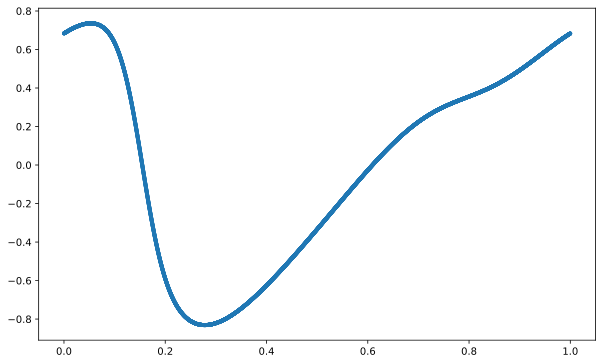

In [11]:
data_path = "data/burgers_data_R10.mat"
dataloader = MatReader(data_path)

L = 1
gridsize = 2**13
x_data = dataloader.read_field("a")[:, :].unsqueeze(-1)
y_data = dataloader.read_field("u")[:, :]
num_data = x_data.size(0)

grid = torch.linspace(0, L, gridsize + 1)[:-1].unsqueeze(-1)
x_data = torch.cat((x_data, grid.repeat([num_data, 1, 1])), dim=-1)
grid = grid.squeeze()

print("number of data:", num_data)
print("grid size:",  gridsize)

delta_start = 1 / 2 * grid[1].unsqueeze(0)
delta_end = 1 / 2 * (1 - grid[-2]).unsqueeze(0)
delta_mid = 1 / 2 * (grid[2:] - grid[:-2])
delta_x = torch.cat((delta_start, delta_mid, delta_end))
print("the first ten delta x for example:",delta_x[0:10])

plt.figure(figsize=(10, 6))
plt.scatter(grid, y_data[0, :], marker=".")

In [13]:
modes = 65
bases_types = ["Fourier", "Principal"]
bases_type = bases_types[0]

plt.figure(figsize=(10, 6))
if bases_type == "Fourier":
    fbases = torch.zeros((gridsize, modes))
    fbases[:, 0] = 1 / math.sqrt(L)
    for i in range(modes // 2):
        fbases[:, 2 * i + 1] = math.sqrt(2 / L) * torch.cos(
            2 * torch.pi * (i + 1) * grid / L
        )
        if 2 * i + 2 <= modes - 1:
            fbases[:, 2 * i + 2] = math.sqrt(2 / L) * torch.sin(
                2 * math.pi * (i + 1) * grid / L
            )
    bases = fbases
    print(bases.size(), delta_x.size())
    wbases = torch.einsum("sm,s->sm", fbases, delta_x)
elif bases_type == "Principal":
    num_inPCA = 2 * 6
    pca_data = y_data[:num_inPCA, :].T
    plt.scatter(grid, pca_data[:, 0], marker=".", label="u")
    U, S, VT = np.linalg.svd(pca_data)
    fbases = U[:, :modes] / np.sqrt(L / s)
    wfbases = L / gridsize * fbases
    bases = torch.from_numpy(fbases.astype(np.float32))
    wbases = torch.from_numpy(wfbases.astype(np.float32))
    
for i in range(3):
    plt.scatter(grid, fbases[:, i], marker=".", label="base" + str(i + 1))
plt.legend()
print(f"verify orthonormality: Int(base3^2 dx)={sum(bases[:, 3] * wbases[:, 3]).item()},Int(base3*base5 dx)={sum(bases[:, 3] * wbases[:, 5]).item()}")

torch.Size([8192, 65]) torch.Size([8192])
verify orthonormality: Int(base3^2 dx)=0.9998778700828552,Int(base3*base5 dx)=-0.0001220843696501106


In [ ]:
fig,ax=plt.subplots(nrows=3)
for i in range(3):
    j=-i-128
    x=x_data[j,:,:]
    y=y_data[j,:]
    y_pred=model(x,bases=bases,wbases=wbases)
    ax[i].plot(grid,x,label="u")
    ax[i].plot(grid,y,label="")
    ax[i].plot(grid,y_pred)
    